# Extended Kalman Filter design for bicycle's kinematic motion model

In [3]:
# Import dependencies
from __future__ import division, print_function
%matplotlib inline

import scipy
import sympy
from sympy import Symbol, symbols, Matrix, sin, cos, latex
from sympy.interactive import printing
printing.init_printing()
sympy.init_printing(use_latex="mathjax", fontsize='16pt')

from BicycleTrajectory2D import *
from BicycleUtils import *
from FormatUtils import *
from PlotUtils import *

## Simulation of kinematic motion model

In [4]:
[N, dt, wheel_distance] = [300, 0.05, 1.1]  # simulation parameters
add_noise = True  # Enable/disable gaussian noise

# Define initial state --------------------------------------------------------
delta = math.radians(6)  # steering angle
phi = math.radians(0)  # Lean angle
X_init = np.array([1.0, 3.0, 0.0, np.tan(delta)/wheel_distance, 0.0, phi]) # [x, y, z, sigma, psi, phi]

# Define constant inputs ------------------------------------------------------
U_init = np.array([1.0, 0.01, 0.01]) # [v, phi_dot, delta_dot]

# Define standard deviation for gaussian noise model --------------------------
# [xf, xr, yf, yr, zf, zr, za, delta, psi, phi]
if add_noise:
    noise = [0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01]
else:
    noise = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    
# Create object simulator ------------------------------------------------------
bike = BicycleTrajectory2D(X_init=X_init, U_init=U_init, noise=noise)

# Simulate path ----------------------------------------------------------------
(gt_sim, zs_sim, time) = bike.simulate_path(N=N, dt=dt)

# Plot simulation results
#plot_results(xs=[], zs_sim=zs_sim, gt_sim=gt_sim, time=time, plot_xs=False)

## Implementation of EKF for $\sigma$-model

### Define state vector:

$$ X = 
\begin{bmatrix}x & y & z & v & \sigma & \psi & \phi \end{bmatrix}^\mathsf T$$

### Define measurement vector:

$$ Z = 
\begin{bmatrix}x_f & x_r & y_f & y_r & z_f & z_r & z_a & \sigma & \psi & \phi \end{bmatrix}^\mathsf T$$

In [5]:
x, y, v, psi, phi, delta, time, w, sigma, z = symbols('x y v \psi \phi \delta T w sigma z')
delta_dot, v_dot, phi_dot = symbols('delta_dot v_dot phi_dot')

fxu = Matrix([[x + time*v*sympy.cos(psi)],
              [y + time*v*sympy.sin(psi)],
              [z],
              [sigma + (time*delta_dot/w)*(1+(w**2)*(sigma**2))],
              [psi + time*v*sigma/sympy.cos(phi)],
              [phi + time*phi_dot]
             ])

state = Matrix([x, y, z, sigma, psi, phi])   # Define state
F = fxu.jacobian(state)                      # Compute Jacobian of F with respecto to states
inputs = Matrix([v, phi_dot, delta_dot])     # Define inputs
V = fxu.jacobian(inputs)                     # Compute Jacobian of F with respecto to inputs

### Define state transition function $F$

In [6]:
fxu
#print (latex(fxu))

⎡   T⋅v⋅cos(\psi) + x   ⎤
⎢                       ⎥
⎢   T⋅v⋅sin(\psi) + y   ⎥
⎢                       ⎥
⎢           z           ⎥
⎢                       ⎥
⎢        ⎛ 2  2    ⎞    ⎥
⎢T⋅δ_dot⋅⎝σ ⋅w  + 1⎠    ⎥
⎢─────────────────── + σ⎥
⎢         w             ⎥
⎢                       ⎥
⎢     T⋅σ⋅v             ⎥
⎢   ───────── + \psi    ⎥
⎢   cos(\phi)           ⎥
⎢                       ⎥
⎣    T⋅φ_dot + \phi     ⎦

### Compute Jacobian of $F$ with respect to state $x$

In [7]:
F
#print (latex(F))

⎡1  0  0          0          -T⋅v⋅sin(\psi)         0       ⎤
⎢                                                           ⎥
⎢0  1  0          0          T⋅v⋅cos(\psi)          0       ⎥
⎢                                                           ⎥
⎢0  0  1          0                0                0       ⎥
⎢                                                           ⎥
⎢0  0  0  2⋅T⋅δ_dot⋅σ⋅w + 1        0                0       ⎥
⎢                                                           ⎥
⎢                T⋅v                         T⋅σ⋅v⋅sin(\phi)⎥
⎢0  0  0      ─────────            1         ───────────────⎥
⎢             cos(\phi)                            2        ⎥
⎢                                               cos (\phi)  ⎥
⎢                                                           ⎥
⎣0  0  0          0                0                1       ⎦

### Compute Jacobian of $F$ with respect to inputs $u$

In [8]:
V
#print (latex(V))

⎡T⋅cos(\psi)  0        0      ⎤
⎢                             ⎥
⎢T⋅sin(\psi)  0        0      ⎥
⎢                             ⎥
⎢     0       0        0      ⎥
⎢                             ⎥
⎢                  ⎛ 2  2    ⎞⎥
⎢                T⋅⎝σ ⋅w  + 1⎠⎥
⎢     0       0  ─────────────⎥
⎢                      w      ⎥
⎢                             ⎥
⎢    T⋅σ                      ⎥
⎢ ─────────   0        0      ⎥
⎢ cos(\phi)                   ⎥
⎢                             ⎥
⎣     0       T        0      ⎦

### Implement EKF filter

In [9]:
class EKF_sigma_model_fusion(object):
    """Implements an EKF to bicycle model"""
    def __init__(self, xs, P, R_std, Q_std, wheel_distance=1.2, dt=0.1, alpha=1.0):
        self.w = wheel_distance        #Set the distance between the wheels
        self.xs = xs *0.0    #Set the initial state
        self.P = P      #Set the initial Covariance
        self.dt = dt
        self.R_std = R_std
        self.Q_std = Q_std
        self.alpha = alpha
        #self.K = np.zeros((6, 6)) # Kalman gain
        self.K = np.eye(6)*0.5 # Kalman gain
        
        #Set the process noise covariance
        self.Q = np.diag([self.Q_std[0], # v
                          self.Q_std[1], # phi_dot
                          self.Q_std[2]  # delta_dot
                          ])
        
        # Set the measurement noise covariance
        self.R = np.diag([self.R_std[0],  # xf
                          self.R_std[1],  # xr
                          self.R_std[2],  # yf
                          self.R_std[3],  # yr
                          self.R_std[4],  # zf
                          self.R_std[5],  # zr
                          self.R_std[6],  # za
                          self.R_std[7],  # sigma
                          self.R_std[8],  # psi
                          self.R_std[9]]) # phi
        
        # Linear relationship H -  z = Hx
        self.H = np.zeros((10, 6))  # 10 measurements x 6 state variables
        [self.H[0, 0], self.H[1, 0]] = [1.0, 1.0]  # x
        [self.H[2, 1], self.H[3, 1]] = [1.0, 1.0]  # y
        [self.H[4, 2], self.H[5, 2], self.H[6, 2]] = [1.0, 1.0, 1.0]  # z
        [self.H[7, 3], self.H[8, 4], self.H[9, 5]] = [1.0, 1.0, 1.0]  # sigma - psi - phi
        
    def Fx(self, xs, u):
        """ Linearize the system with the Jacobian of the x """
        F_result = np.eye(len(xs))
        
        v = u[0]
        phi_dot = u[1]
        delta_dot = u[2]
        
        sigma = xs[3]
        psi = xs[4]
        phi = xs[5]
        t = self.dt

        F04 = -t * v * np.sin(psi) 
        F14 = t * v * np.cos(psi)
        F33 = (2 * t * delta_dot * sigma * self.w) + 1
        F43 = (t * v)/np.cos(phi)
        F45 = t * sigma * v * np.sin(phi) / np.cos(phi)**2

        F_result[0, 4] = F04
        F_result[1, 4] = F14
        F_result[3, 3] = F33
        F_result[4, 3] = F43
        F_result[4, 5] = F45

        return F_result
    
    def Fu(self, xs, u):
        """ Linearize the system with the Jacobian of the u """
        v = u[0]
        phi_dot = u[1]
        delta_dot = u[2]
        
        sigma = xs[3]
        psi = xs[4]
        phi = xs[5]
        t = self.dt
        
        V_result = np.zeros((len(xs), len(u)))
        
        V00 = t * np.cos(psi)
        V10 = t * np.sin(psi)
        V32 = (t/self.w)*((sigma**2)*(self.w**2) + 1)
        V40 = t * sigma / np.cos(phi)
        V51 = t

        V_result[0, 0] = V00
        V_result[1, 0] = V10
        V_result[3, 2] = V32
        V_result[4, 0] = V40
        V_result[5, 1] = V51

        return V_result
    
    def f(self, xs, u):
        """ Estimate the non-linear state of the system """
        v = u[0]
        phi_dot = u[1]
        delta_dot = u[2]
        
        sigma = xs[3]
        psi = xs[4]
        phi = xs[5]
        t = self.dt
               
        fxu_result = np.zeros((len(xs), 1))
        
        fxu_result[0] = xs[0] + t * v * np.cos(psi)
        fxu_result[1] = xs[1] + t * v * np.sin(psi)
        fxu_result[2] = xs[2]
        fxu_result[3] = xs[3] + (t*phi_dot/self.w)*((sigma**2)*(self.w**2) +1)
        fxu_result[4] = xs[4] + t * v * sigma / np.cos(phi)
        fxu_result[5] = xs[5] + t * phi_dot
        
        return fxu_result

    def h(self, x):
        """ takes a state variable and returns the measurement
        that would correspond to that state. """   
        sensor_out = np.zeros((10, 1))
        sensor_out[0] = x[0]
        sensor_out[1] = x[0]
        sensor_out[2] = x[1]
        sensor_out[3] = x[1]
        sensor_out[4] = x[2]
        sensor_out[5] = x[2]
        sensor_out[6] = x[2]
        sensor_out[7] = x[3] # sigma
        sensor_out[8] = x[4] # psi
        sensor_out[9] = x[5] # phi
        
        return sensor_out

    def Prediction(self, u):
        x_ = self.xs
        P_ = self.P
        self.xs = self.f(x_, u)
        self.P = self.alpha * self.Fx(x_, u).dot(P_).dot((self.Fx(x_,u)).T) + \
             self.Fu(x_,u).dot(self.Q).dot((self.Fu(x_,u)).T)
    
    def Update(self, z):
        """Update the Kalman Prediction using the meazurement z"""
        y = z - self.h(self.xs)
        self.K = self.P.dot(self.H.T).dot(np.linalg.inv(self.H.dot(self.P).dot(self.H.T) + self.R))
        
        self.xs = self.xs + self.K.dot(y)
        self.P = (np.eye(len(self.xs)) - self.K.dot(self.H)).dot(self.P)

Execute EKF

In [10]:
np.random.seed(850)

file_name = "filters/EKF/math_model/"
[N, dt, wheel_distance, number_state_variables] = [300, 0.05, 1.1, 6]
delta = math.radians(6)
phi = math.radians(0)

#%prun some_useless_slow_function()

U_init = np.array([1.0, 0.01, 0.01]) # [v, phi_dot, delta_dot]
X_init = np.array([1.0, 3.0, 0.0, np.tan(delta)/wheel_distance, 0.0, phi]) # [x, y, z, sigma, psi, phi]

# noise = [xf, xr, yf, yr, zf, zr, za, delta, psi, phi]
if add_noise:
    noise = [0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01]
    file_name += "noise/"
else:
    noise = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    file_name += "no_noise/"

bike = BicycleTrajectory2D(X_init=X_init, U_init=U_init, w=wheel_distance, noise=noise)

(gt_sim, zs_sim, time_t) = bike.simulate_path(N=N, dt=dt)

alpha = 1.0

# covariance matrix
P = np.eye(number_state_variables) * 1e0

# Input noise covariance M
M_std = [(0.001)**2, (0.001)**2, (0.001)**2 ] # v, phi_dot, delta_dot

# Measurement noise covariance R 
# [xf, xr, yf, yr, zf, zr, za, delta, psi, phi]
R_std = [0.8**2, 0.8**2,  # x
         0.8**2, 0.8**2,  # y
         0.5**2, 0.5**2, 0.5**2,  # z
         0.5**2, 0.4**2, 1.8**2] # delta - psi - phi

filter_ekf = EKF_sigma_model_fusion(X_init, P, R_std=R_std, Q_std=M_std, wheel_distance=wheel_distance, dt=dt, alpha=alpha)

xs = np.zeros((N, number_state_variables))
ps = np.zeros((N, number_state_variables, number_state_variables))
PU = np.zeros((N, number_state_variables))
KU = np.zeros((N, number_state_variables))
time_t = np.zeros((N, 1))
t = 0
z_t = np.zeros((10, 1))

for i in range(N): 
    P = filter_ekf.P
    K = filter_ekf.K
    PU[i] = [P[0,0], P[1,1], P[2,2], P[3,3], P[4,4], P[5,5]]
    KU[i] = [K[0,0], K[1,1], K[2,2], K[3,3], K[4,4], K[5,5]]
    
    xs[i] = filter_ekf.xs.T
    xs[i, 3] = np.arctan2(xs[i, 3], 1/wheel_distance)  # sigma to delta conversion
    
    # predict
    filter_ekf.Prediction(U_init)
    
    # update measurements [xf, xr, yf, yr, zf, zr, za, delta, psi, phi]
    z_t[0] = zs_sim[i].xf
    z_t[1] = zs_sim[i].xr
    z_t[2] = zs_sim[i].yf
    z_t[3] = zs_sim[i].yr
    z_t[4] = zs_sim[i].zf
    z_t[5] = zs_sim[i].zr
    z_t[6] = zs_sim[i].za
    z_t[7] = np.tan(zs_sim[i].delta)/wheel_distance  # sigma
    z_t[8] = zs_sim[i].psi # psi
    z_t[9] = zs_sim[i].phi # phi

    filter_ekf.Update(z_t)
    
    cov = np.array([[P[0, 0], P[2, 0]], 
                    [P[0, 2], P[2, 2]]])
    mean = (xs[i, 0], xs[i, 1])

    #plot_covariance_ellipse(mean, cov, fc='g', std=3, alpha=0.3, title="covariance")
    
    time_t[i] = t
    t += dt
    filter_ekf.time_t = t

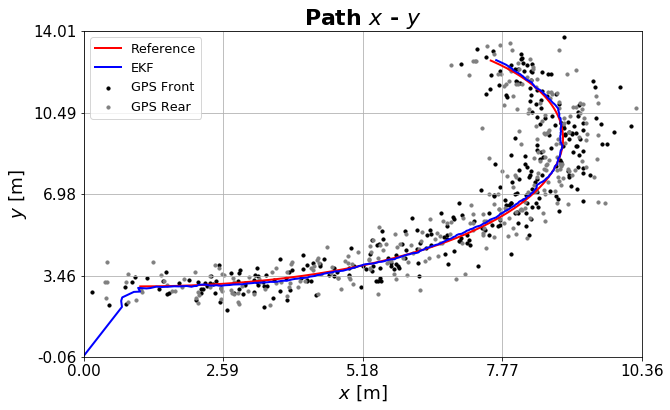

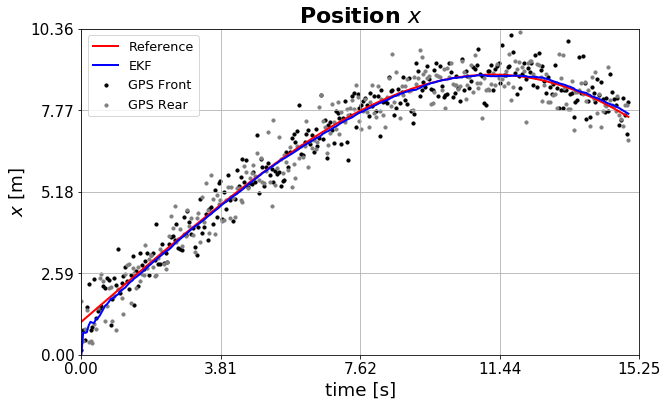

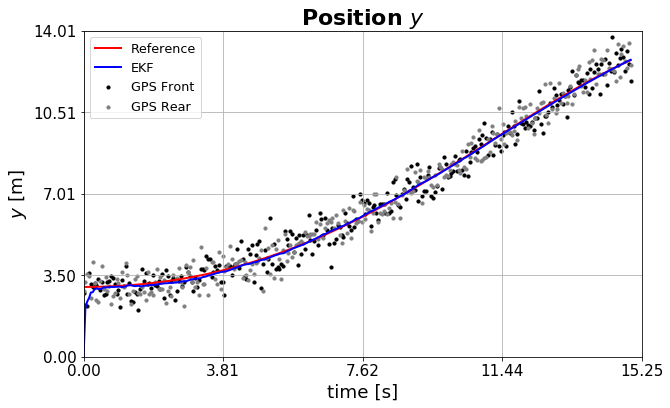

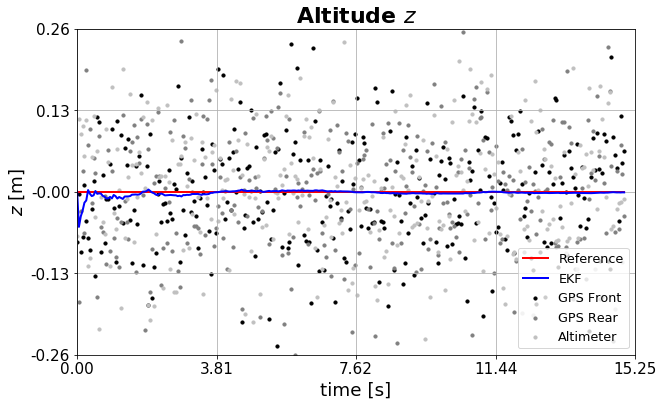

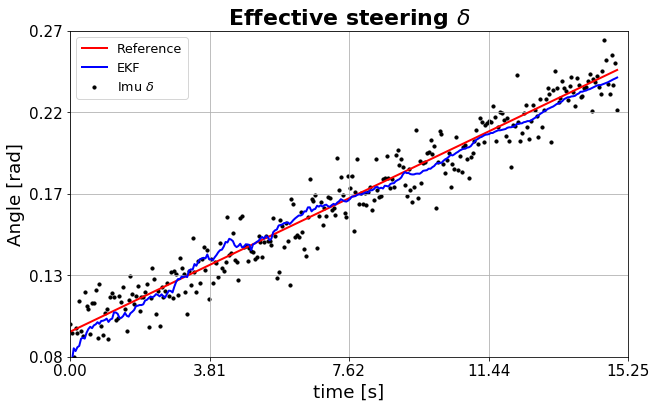

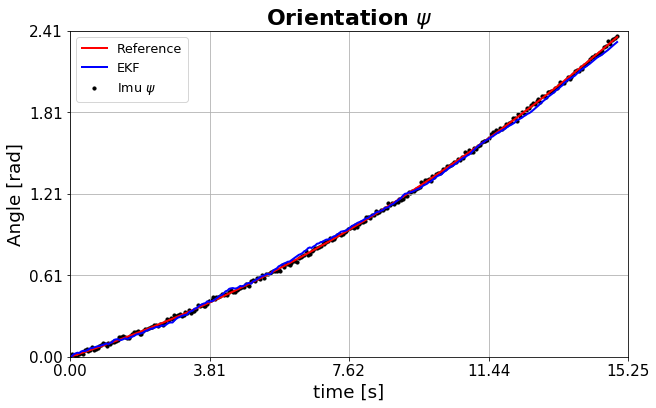

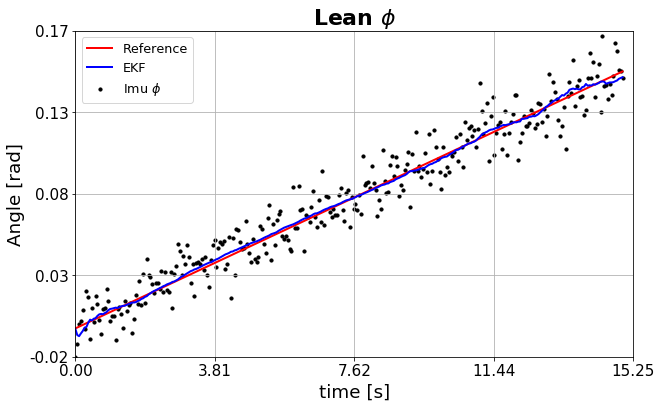

In [11]:
filter_name = 'EKF'
(gt, zs) = convert_object_to_array(gt_sim, zs_sim)
plot_filter_results(xs, gt, zs, time_t, file_name, filter_name)

Plot Kalman gain and process covariance

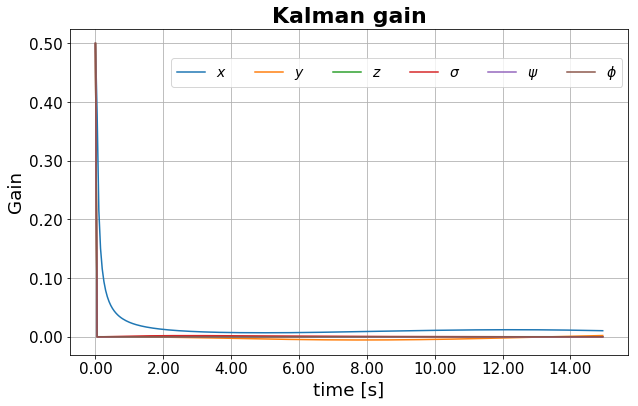

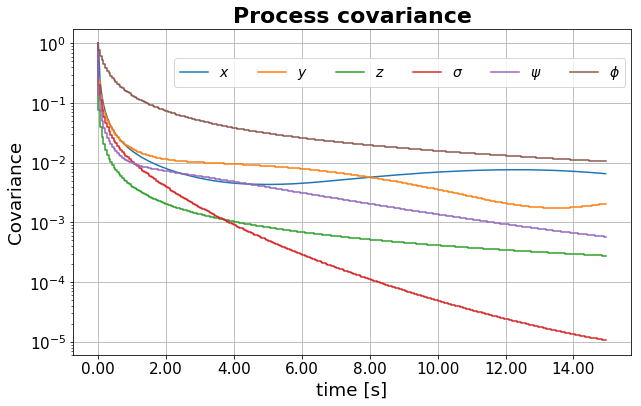

In [12]:
plot_EKF_gain_covariance(time_t, KU, PU, file_name, autoscale_axis=True)